# 1 fold experiments

In [1]:
import os
import sys
import random
import pickle
from datetime import datetime
from collections import defaultdict

import albumentations as albu
from albumentations.pytorch import ToTensor
from tqdm import tqdm
import cv2
import numpy as np
import pandas as pd
import jpeg4py as jpeg
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import (
    Dataset, 
    DataLoader, 
    SubsetRandomSampler,
    SequentialSampler,
    Sampler)
import segmentation_models_pytorch as smp

from configs import (
    TRAIN_NON_EMPTY_PATH,
    TRAIN_PATH,
    TEST_PATH,
    IMAGES_TO_EXCLUDE0,
    IMAGES_TO_EXCLUDE2
)
from utils import (
    rle2mask,
    mask2rle,
    show_images_with_defects,
    plot_loss_metrics,
    plot_batch_metrics,
    _fix_seeds
)
from samplers import ClassProbSampler, SubsetSequentSampler
from datasets import SteelTrainDataset
from losses import (
    BCEDiceLoss,
    BCELogitsLoss,
    BCEDiceWeightedLoss,
    BCEWeightedLoss,
    FocalLoss,
)
#from metrics import SoftDiceMetric, dice_coeff_mean
from trainers import Trainer

%matplotlib inline
device = torch.device("cuda:0")
#device = torch.device("cpu")

with open('../input_data/train_dict.pcl', 'rb') as handle:
    train_dict = pickle.load(handle)
    
with open('../input_data/train_class_images.pcl', 'rb') as handle:
    train_class_images = pickle.load(handle)
    
with open('../input_data/train_image_class.pcl', 'rb') as handle:
    train_image_class = pickle.load(handle)

## Pipeline

In [2]:
print(len(IMAGES_TO_EXCLUDE0))
exclude_img_list = list(set(IMAGES_TO_EXCLUDE0))
print(len(exclude_img_list))

166
160


In [3]:
class_weights_sampler = {
    0: 1,#64/29.,
    1: 1,#64/4.,
    2: 1,#64/2.,
    3: 1,#64/25.,
    4: 1,#64/4.,    
}
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
#mean = (0.301, 0.301, 0.301)
#std = (0.138, 0.138, 0.138)

TRAIN_BATCH_SIZE = 4#16
VALID_BATCH_SIZE = 8
DEVICE = device
SEED = 42

def _init_fn(worker_id):
    _fix_seeds()
    
_fix_seeds(SEED)

train_transforms = albu.Compose([
                albu.HorizontalFlip(always_apply=False, p=0.5),
                #albu.VerticalFlip(always_apply=False, p=0.5),
                #albu.RandomBrightnessContrast(brightness_limit=0.25, contrast_limit=0.25, p=0.5),
                #albu.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10, p=0.5),
                #albu.CropNonEmptyMaskIfExists(256, 800, always_apply=True, p=1.0),
                #albu.Resize(height=224, width=224, always_apply=True, p=1.0),
                albu.Normalize(mean=mean, std=std, max_pixel_value=255.0, 
                               always_apply=True, p=1.0)])
valid_transforms = albu.Compose([
                #albu.HorizontalFlip(always_apply=False, p=0.5),
                #albu.VerticalFlip(always_apply=False, p=0.5),
                #albu.CropNonEmptyMaskIfExists(256, 256, always_apply=True, p=1.0),
                #albu.Resize(height=256, width=256, always_apply=True, p=1.0),
                albu.Normalize(mean=mean, std=std, max_pixel_value=255.0, 
                               always_apply=True, p=1.0)])

train_dataset = SteelTrainDataset(TRAIN_PATH, train_dict, 
                                  train_transforms, exclude_images=exclude_img_list)
valid_dataset = SteelTrainDataset(TRAIN_PATH, train_dict, 
                                  valid_transforms, exclude_images=exclude_img_list)
print(len(train_dataset))
print(len(valid_dataset))

train_loader_params = {
    'batch_size':TRAIN_BATCH_SIZE,
    'shuffle':False,
    'pin_memory':False,
    'num_workers':8
}
valid_loader_params = {
    'batch_size':VALID_BATCH_SIZE,
    'shuffle':False,
    'pin_memory':False,
    'num_workers':8
}

train_sampler_params = {'sampler_name':'SubsetRandomSampler'}
valid_sampler_params = {'sampler_name':'SubsetRandomSampler'}

#model = smp.Unet(encoder_name='resnet18', encoder_weights='imagenet', classes=4, activation=None)
                 
#optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
#optimizer = optim.SGD(model.parameters(), lr=5e-2, momentum=0.9, weight_decay=1e-6)

#lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=2, factor=0.1)
#lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-5, last_epoch=-1)
#lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

12408
12408


In [4]:
class_weights_loss = {
    1:1,#2, 
    2:1,#4, 
    3:1, 
    4:1,#1
}
loss = BCEDiceWeightedLoss(smooth=1e-6, dice_loss_weight=1, class_weights=class_weights_loss)
#loss = FocalLoss(alpha=0.8, gamma=2)

trainer = Trainer('../models/05_model_07.pth', 
                 loss,
                 train_dataset, train_loader_params, train_sampler_params,
                 valid_dataset, valid_loader_params, valid_sampler_params,
                 0.2,
                 device = DEVICE,
                 pred_threshold=0.5,
                 num_epochs=25)

optimizer_params = {'optimizer_name':'sgd', 'lr': 1e-3, 'momentum': 0.9, 'weight_decay': 1e-4}
scheduler_params = {'scheduler_name':'cos', 'T_max': 5, 'eta_min': 1e-5, 'last_epoch': -1}
#scheduler_params = {'scheduler_name':'redonplat',}
model_params = {'model_name':'unet', 'decoder_channels':(512, 256, 128, 64, 32, 16),
                'encoder_name':'resnet50', 
                'encoder_weights':'imagenet', 'activation':None}
model, optimizer, lr_scheduler = trainer.make_model(model_params, optimizer_params, scheduler_params)

In [5]:
%%time
trainer.run_model(model, optimizer, lr_scheduler)

Starting epoch: 0 | time: 00:32:09
LR: [0.001]
valid: 100%|██████████| 311/311 [01:41<00:00,  3.07it/s, dice_batch - 0.9629, bce_dice_weighted_loss - 3.214]
Valid avg loss: 3.2523732315689036
Valid avg dice: 0.8700088109234139
*** Model saved! ***

Starting epoch: 1 | time: 00:58:27
LR: [0.000657963412215599]
valid: 100%|██████████| 311/311 [01:42<00:00,  3.03it/s, dice_batch - 0.9653, bce_dice_weighted_loss - 3.187]
Valid avg loss: 3.001609335758295
Valid avg dice: 0.7400571942521061
*** Model saved! ***

Starting epoch: 2 | time: 01:24:46
LR: [0.00010453658778440107]
valid: 100%|██████████| 311/311 [01:40<00:00,  3.09it/s, dice_batch - 0.9751, bce_dice_weighted_loss - 3.147]
Valid avg loss: 2.905977615972807
Valid avg dice: 0.8062033864079564
*** Model saved! ***

Starting epoch: 3 | time: 01:51:00
LR: [0.00010453658778440096]
valid: 100%|██████████| 311/311 [01:40<00:00,  3.09it/s, dice_batch - 0.9735, bce_dice_weighted_loss - 3.151]
Valid avg loss: 2.8988428422492416
Valid avg dice

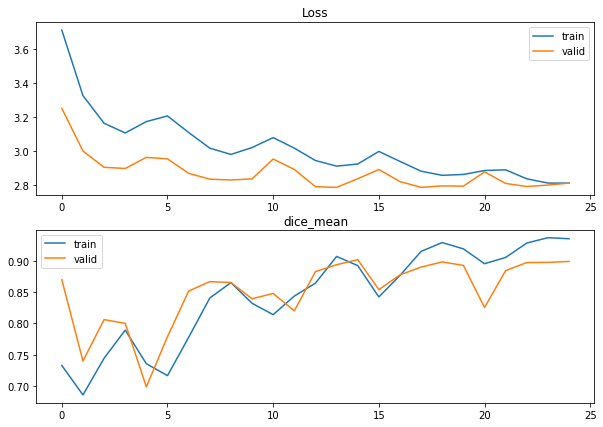

In [6]:
#  resnet50, decoder(512,256,128,64,32,16), 
# dice_w_loss=1,  lr=1e-3 cl_w = (1,1,1,1) RCrop(256,1600) 05_model_07
plot_loss_metrics(trainer.loss_history, {'dice_mean':trainer.dice_history})

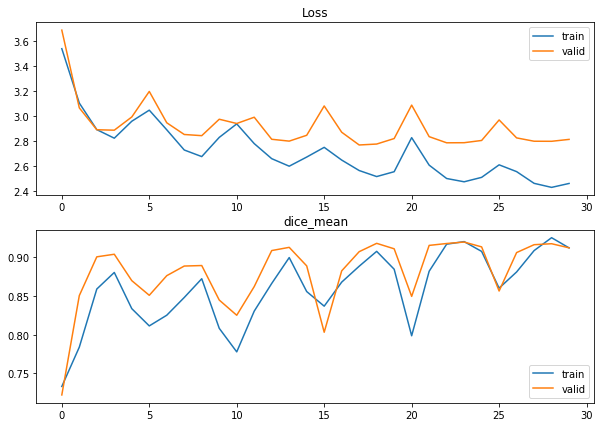

In [6]:
# 0.906947 resnet34, dice_w_loss=1,  lr=5e-3 cl_w = (1,1,1,1)
plot_loss_metrics(trainer.loss_history, {'dice_mean':trainer.dice_history})

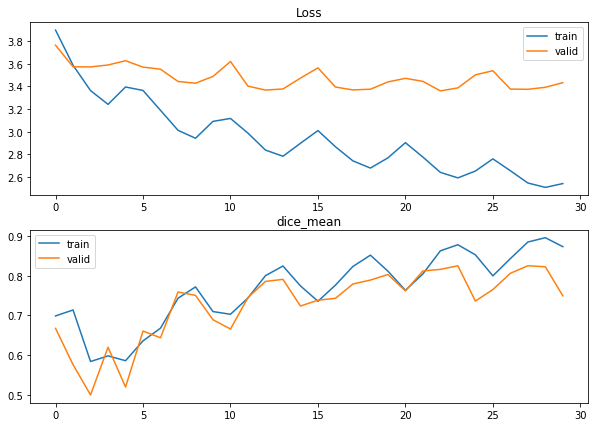

In [6]:
# resnet34, dice_w_loss=1e-1,  lr=5e-4
plot_loss_metrics(trainer.loss_history, {'dice_mean':trainer.dice_history})

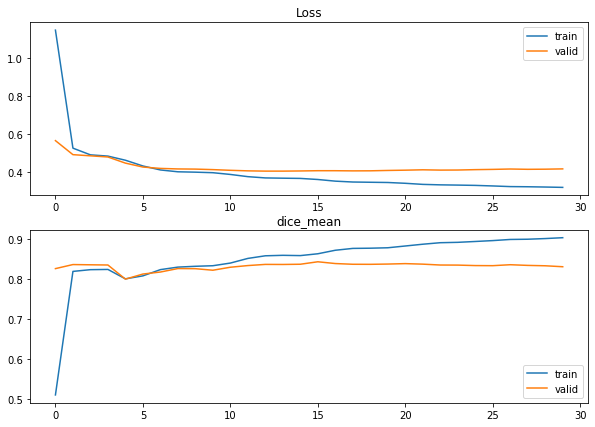

In [6]:
# resnet34, dice_w_loss=1e-1,  lr=5e-4
plot_loss_metrics(trainer.loss_history, {'dice_mean':trainer.dice_history})